In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from scipy.stats import linregress
from mpl_toolkits.mplot3d import Axes3D

In this jupternotebook

1. We will measure the $\kappa$ of different tissues by setting external pressure around PH and verify that $\kappa$ can be treated as a constant.(constant pressure ensemble)

2. We will measure the $\kappa$ in constant growth rate ensemble.

3. We will examine the theory of  tissue competition solely dependent on $P_H$. We will curvefit the competition dynamics by the logistic solution of $\phi$ and acquire the parameters $\kappa \Delta P_H $: 

\begin{equation}
\phi = \frac{1}{1+e^{-\kappa \Delta P_H (t-t_0)}}
\end{equation}

$\Delta P_H$ can be directly calculated by the formula of $P_H$ linear approximation. Thus we will plot a picture of $\kappa \Delta P_H$ as a function of $\Delta P_H$, and the slope of the data is expected as around $\kappa$ by this theory.  

3. Finally, we will compare the value of $\kappa$ obtained by three approaches.

I. Measure $\kappa$ by constant pressure ensemble

Goal: By plotting the relation between growth rate and pressure, linear expansion is performed where the pressure is close to $P_H$ to obtain the value of kappa

Steps:
1. acquire growth rate by the file __curp.dat, the sixth column of the data is $\chi^3$, which is the rescaling factor of the system, $\chi^2 = \frac{V'}{V}=\frac{V'-V}{V}+1= \frac{\partial_t n}{n}+1 = k+1$, calculate the average of $\chi_2$ over a long time, then calculate average $k =\chi^2-1$. 
2. acquire the difference of PH to imposed pressure by the folder name.
3. plot the relation between growth rate and pressure and the pressure difference
4. y = kappa (P_H-P) as the fitting function to the linear expansion around P_H and acquire kappa


Text(0, 0.5, 'system size $log(L_x)$')

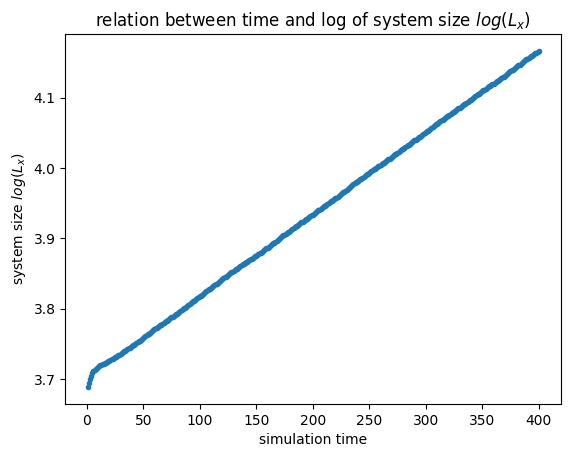

In [2]:
path = r'./project_kappa2/f1_5.0/G_40/PT_18.0000000000'
data = pd.read_csv(path+'/__curp.dat',sep='\t',header = None)
data
data2=data.iloc[:,[0,8]]
time, systemsize =data2.iloc[:,0],data2.iloc[:,1]
plt.plot(time,np.log(systemsize),'.')
plt.title('relation between time and log of system size $log(L_x)$')
plt.xlabel('simulation time')
plt.ylabel('system size $log(L_x)$')

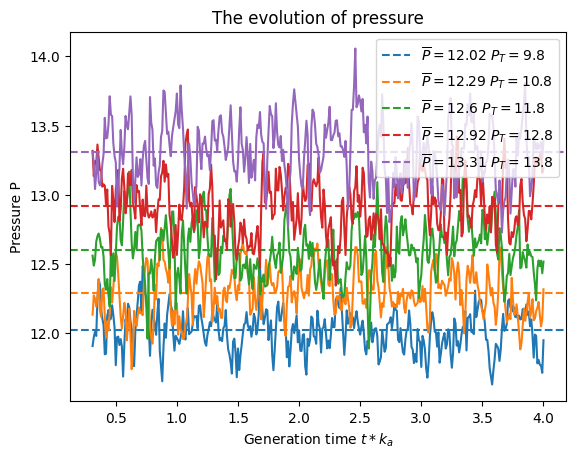

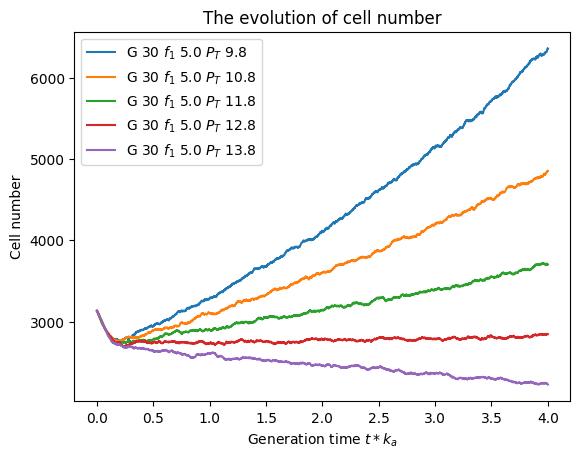

In [3]:
main_dir = './project_kappa2'
f1_folders = [folder for folder in os.listdir(main_dir) if folder.startswith('f1_')]
ka=0.01# apoptosis rate
relaxation_time = 30
G_values = []
f1_values = []
kappa_values = []
fig,ax_p=plt.subplots()
fig,ax_n=plt.subplots()

for f1_folder in f1_folders[:1]:
    f1_value = float(f1_folder.split('_')[1])  # Extract f1 value from folder name
    f1_path = os.path.join(main_dir, f1_folder)
    G_folders = [folder for folder in os.listdir(f1_path) if folder.startswith('G_')]
    
    for G_folder in G_folders[:1]:
        G_value = int(G_folder.split('_')[1])  # Extract G value from folder name
        G_path = os.path.join(f1_path, G_folder)
        subsubfolders = [folder for folder in os.listdir(G_path) if folder.startswith('PT_')]
        
        k_values = []
        delta_P_values = []
        
        for subsubfolder in subsubfolders[:5]:
            PT_path = os.path.join(G_path, subsubfolder)     
            PT = np.round(float(subsubfolder.split('_')[-1]),2)
            curp_path = os.path.join(PT_path, '__curp.dat')
            num_path = os.path.join(PT_path,'numcells.dat')
            p_data = pd.read_csv(curp_path,sep='\t',header = None,skiprows=relaxation_time)
            time_data,pressure_data = p_data.iloc[:,0]*ka,p_data.iloc[:,1]
            plot_line =ax_p.plot(time_data,pressure_data)
            avg_pressure = np.mean(pressure_data)
            color = plot_line[0].get_color()  # Get the color of the current plot line
            ax_p.axhline(y=avg_pressure, linestyle='--', color=color,label =r'$\overline{P}=' + f'{np.round(avg_pressure,2)}$ $P_T=${PT}')
            n_data = pd.read_csv(num_path,sep='\t',header = None)
            t_data,num_data = n_data.iloc[:,0]*ka,n_data.iloc[:,1]
            ax_n.plot(t_data,num_data,label = f'G {G_value} $f_1$ {f1_value} $P_T$ {PT}')
ax_p.set_title('The evolution of pressure')
ax_p.set_xlabel(r'Generation time $t*k_a$')
ax_p.set_ylabel('Pressure P')
ax_p.legend()
ax_n.set_title('The evolution of cell number')
ax_n.set_xlabel(r'Generation time $t*k_a$')
ax_n.set_ylabel('Cell number')
ax_n.legend()

<>:47: SyntaxWarning: invalid escape sequence '\k'
<>:48: SyntaxWarning: invalid escape sequence '\k'
<>:105: SyntaxWarning: invalid escape sequence '\k'
<>:47: SyntaxWarning: invalid escape sequence '\k'
<>:48: SyntaxWarning: invalid escape sequence '\k'
<>:105: SyntaxWarning: invalid escape sequence '\k'
/tmp/ipykernel_1381/1265969780.py:47: SyntaxWarning: invalid escape sequence '\k'
  ax1.plot(PT_space,k_space,label=f'Fit: $\kappa=${np.round(popt[0],4)}')
/tmp/ipykernel_1381/1265969780.py:48: SyntaxWarning: invalid escape sequence '\k'
  ax2.plot(dP_space,k_space,label=f'Fit: $\kappa=${np.round(popt[0],4)}')
/tmp/ipykernel_1381/1265969780.py:105: SyntaxWarning: invalid escape sequence '\k'
  plt.title('$f_1$ vs $\kappa$ for different G values')


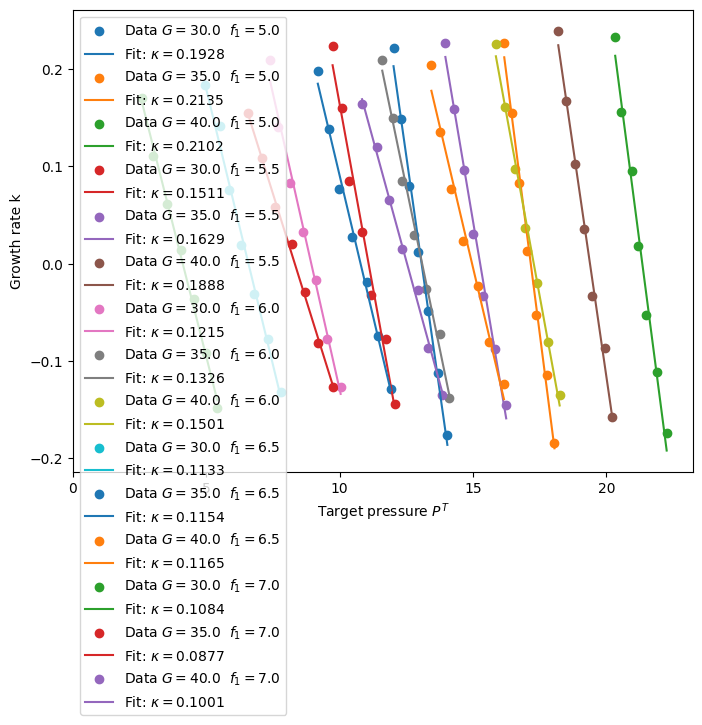

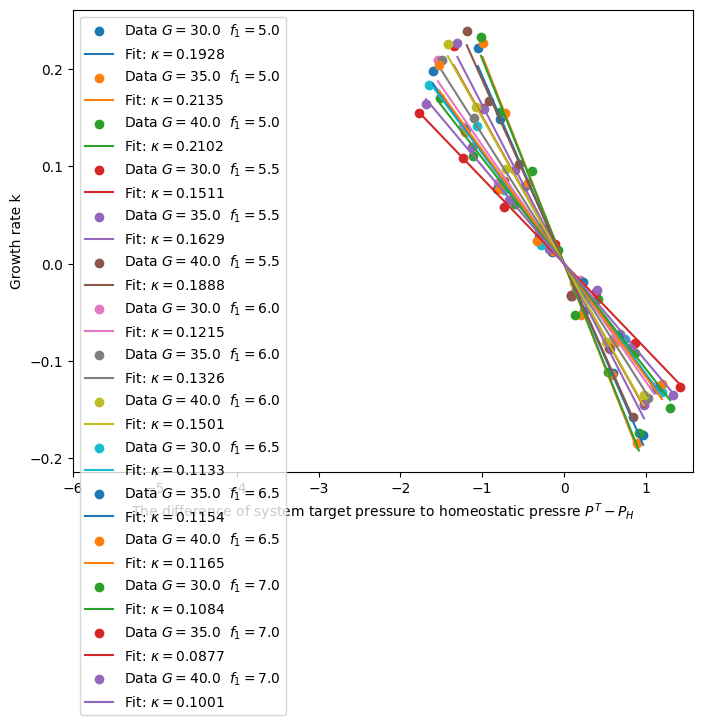

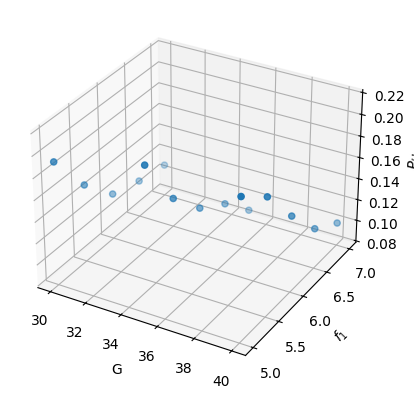

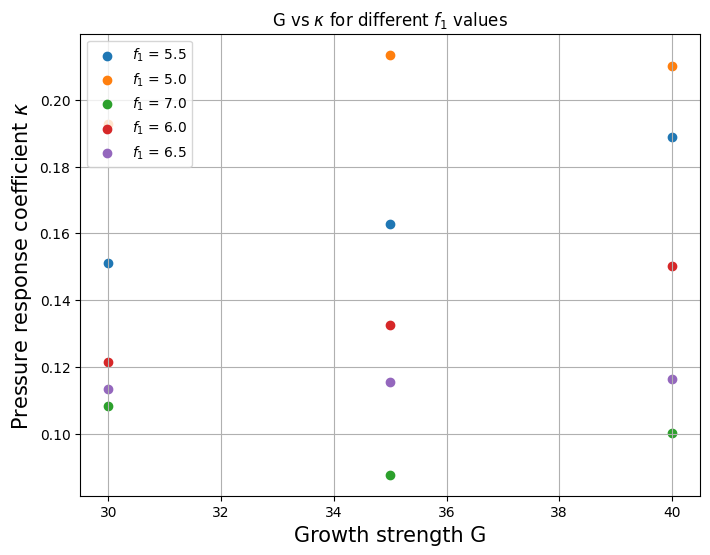

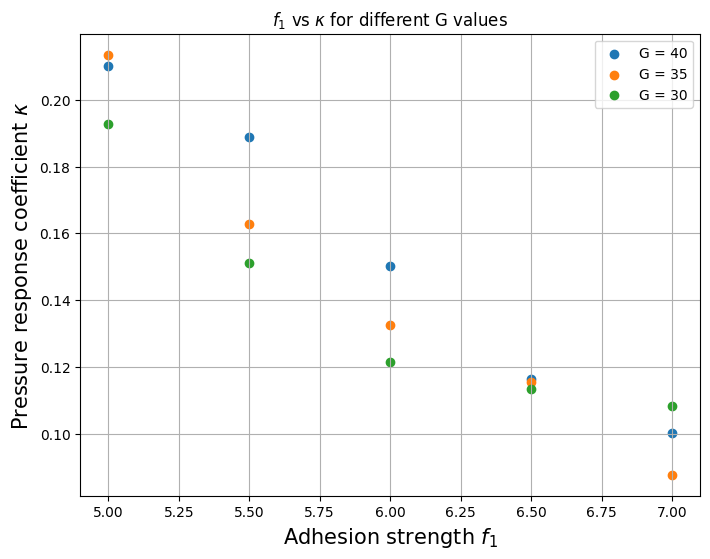

In [4]:
ka=0.01
def fitting_kappa(x,kappa,PH):#fitting function for kappa
    return kappa*(PH-x)

def get_chi3_pressure(path):#read __curp.dat and get average value of chi3
    data = pd.read_csv(path,sep='\t',header = None)
    chi3=data.iloc[30:,5].mean()
    PT = data.iloc[30:,1].mean() #system pressure
    #PT = float(path.split('/')[4].split('_')[1])
    f1,G = float(path.split('/')[2].split('_')[1]),float(path.split('/')[3].split('_')[1]) 
    return f1,G,PT,chi3
G_values = []
f1_values = []
kappa_values = []
fig1,ax1 = plt.subplots(figsize=(8, 6))
fig2,ax2 = plt.subplots(figsize=(8, 6))
current_path = r'./project_kappa2'
folders = sorted(f for f in os.listdir(current_path) if os.path.isdir(os.path.join(current_path,f)) and f.startswith('f1'))
for folder in folders: #loop f1
    f1_value = float(folder.split('_')[1])
    folder_path = os.path.join(current_path,folder)
    subfolders = sorted(f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path,f)))
    for subfolder in subfolders:# loop G
        G_value = int(subfolder.split('_')[1])
        subfolder_path = os.path.join(folder_path,subfolder)
        subsubfolders= sorted(f for f in os.listdir(subfolder_path) if os.path.isdir(os.path.join(subfolder_path,f)))
        subsubfolders.sort(key = lambda x: float(x.split('_')[1]))
        PT_list = []
        k_list =[]
        for subsubfolder in subsubfolders:#loop PT
            subsubfolder_path = os.path.join(subfolder_path,subsubfolder)
            path = os.path.join(subsubfolder_path,'__curp.dat')
            try:
                f1,G,PT,chi3 = get_chi3_pressure(path)
            except:
                continue
            PT_list.append(PT)
            k_list.append((chi3-1)/ka)
        ax1.scatter(PT_list,k_list,label=r'Data $G=$'+str(G)+r'  $f_1 = $'+str(f1))
        popt,popv = curve_fit(fitting_kappa,PT_list,k_list)
        PH = popt[1]
        ax2.scatter(PT_list-PH,k_list,label=r'Data $G=$'+str(G)+r'  $f_1 = $'+str(f1))
        PT_space = np.linspace(min(PT_list),max(PT_list),100)
        dP_space = PT_space - PH
        k_space = fitting_kappa(PT_space,*popt)
        kappa_values.append(popt[0])
        ax1.plot(PT_space,k_space,label=f'Fit: $\kappa=${np.round(popt[0],4)}')
        ax2.plot(dP_space,k_space,label=f'Fit: $\kappa=${np.round(popt[0],4)}')
        G_values.append(G_value)
        f1_values.append(f1_value)
ax1.legend()
ax2.legend()
ax1.set_xlabel(r'Target pressure $P^T$')
#ax1.set_xlabel(r'Average of system pressure $\overline{P}$')
ax1.set_xlim(0)
ax1.set_ylabel('Growth rate k')
ax2.set_xlabel(r'The difference of system target pressure to homeostatic pressre $P^T - P_H$')
#ax2.set_xlabel(r'The difference of system average pressure to homeostatic pressre $\overline{P} - P_H$')
ax2.set_ylabel('Growth rate k')
ax2.set_xlim(-6)
G_values = np.array(G_values)
f1_values = np.array(f1_values)
kappa_values = np.array(kappa_values)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(G_values, f1_values, kappa_values, label='Data')
ax.set_xlabel('G')
ax.set_ylabel('$f_1$')
ax.set_zlabel('$P_H$')

unique_f1_values = set(f1_values)
plt.figure(figsize=(8, 6)) 

for f1 in unique_f1_values:
    indices = [i for i, value in enumerate(f1_values) if value == f1]
    G_subset = [G_values[i] for i in indices]
    kappa_subset = [kappa_values[i] for i in indices]
    plt.scatter(G_subset, kappa_subset, label=f'$f_1$ = {f1}')

plt.xlabel('Growth strength G',fontsize=15)
plt.ylabel(r'Pressure response coefficient $\kappa$',fontsize=15)
plt.legend()
plt.title(r'G vs $\kappa$ for different $f_1$ values')
plt.grid(True)
plt.show()

unique_G_values = set(G_values)

plt.figure(figsize=(8, 6))  

for g in unique_G_values:
    indices = [i for i, value in enumerate(G_values) if value == g]
    f1_subset = [f1_values[i] for i in indices]
    kappa_subset = [kappa_values[i] for i in indices]
    plt.scatter(f1_subset, kappa_subset, label=f'G = {g}')

indices = [i for i, value in enumerate(G_values) if value == 35]
f1_subset_const_pressure = [f1_values[i] for i in indices]
kappa_list_const_pressure = [kappa_values[i] for i in indices]

plt.xlabel('Adhesion strength $f_1$',fontsize=15)
plt.ylabel(r'Pressure response coefficient $\kappa$',fontsize=15)
plt.legend()
plt.title('$f_1$ vs $\kappa$ for different G values')
plt.grid(True)

II. Constant growth rate ensemble

In this section, we will conduct simulations using the constant growth rate ensemble method to determine the value of $\kappa$. To achieve this, instead of adjusting the system size by the factor $\chi^3 = 1- \beta_T \frac{\Delta t}{t_P}(P_{ext}-P)$, we will scale the system size using a fixed value of $\chi$. This approach ensures that the growth rate remains constant throughout the simulation. The choice of the rescaling factor $\chi$ is crucial, and it should be close to 1 to allow for gradual adjustments in the number of cells in the tissue in response to small changes in the system. When $\chi>>1$, the effects of surface growth become significant and need to be considered.

We vary the tissue parameters $f_1$ and $G$ within specific ranges: $f_1$ ranges from 5.0 to 6.0 with an interval of 0.2, and $G$ ranges from 30 to 40 with an interval of 5. For each pair of tissue parameters, we set the rescaling factor from 0.9998 to 1.0002 with an interval of 0.0001. If the rescaling factor is greater than 1, the initial system size is set to 40; if less than 1, the initial size is set to 90. The simulation time is fixed at 400.

To calculate $\kappa$, we utilize the linear approximation of the growth rate around the homeostatic pressure:

\begin{equation}
\kappa = \frac{\frac{\partial_t n}{n}}{P_H - P} = \frac{k}{P_H - P}
\end{equation}

Here, $k$ represents the growth rate, and $P_H - P$ is the difference between the homeostatic pressure and the system pressure.

The analysis steps are as follows:

1. Measure the homeostatic pressure of each tissue from the simulation with a rescaling factor of 1.
2. Calculate the growth rate using the formula $k = \frac{\partial_t n}{n} = \chi^2 - 1$.
3. Measure the system pressure at 400 simulation times and calculate the average pressure after the system has relaxed.
4. Obtain the value of $\kappa$ for each tissue by linearly fitting $k$ and $(P_H - P)$. Each $\kappa$ corresponds to the tissue parameters $G$ and $f_1$.
5. Plot the relationship between $\kappa$ and $G$ and $f_1$, and analyze the effect of $G$ and $f_1$ on $\kappa$.

__syntax check__
1. Check the pressure, especially when the system become stable, plot the pressure figure

To check it, we plot the figure of system pressure as a function of time

2. Check if growth rate $k = \chi^2 - 1$

To check it, we first calculate growth rate by the formula $k=\frac{\partial_t n}{n} = \frac{n(t+\Delta t)-n(t)}{n(t)\Delta t }$ from numcells.dat, and check if $k=\chi^2 - 1$

<>:44: SyntaxWarning: invalid escape sequence '\c'
<>:44: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_1381/4284695436.py:44: SyntaxWarning: invalid escape sequence '\c'
  ax_k.axhline(y = k,linestyle='--',color=color,label = f'Theoretical $k = \chi^2-1$ scale {scale}')


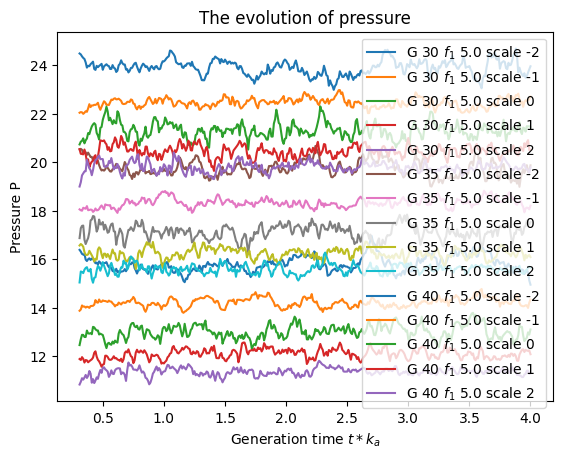

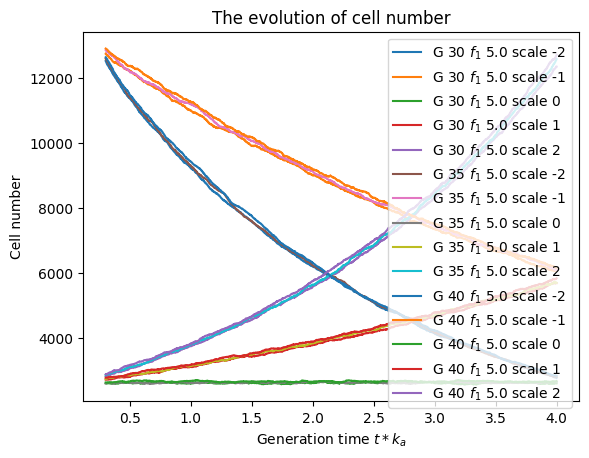

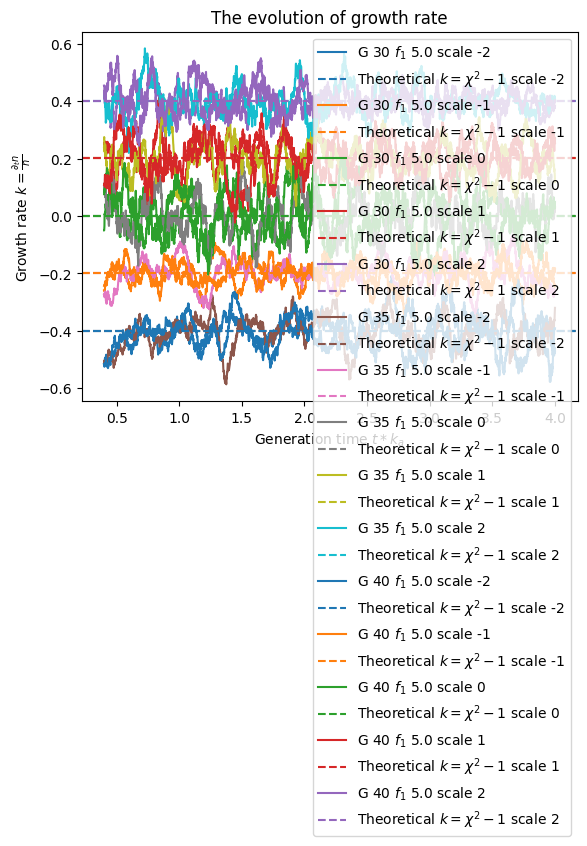

In [5]:
main_dir = './kappa_const_growth_rate2'
f1_folders = [folder for folder in os.listdir(main_dir) if folder.startswith('f1_')]
ka=0.01# apoptosis rate
G_values = []
f1_values = []
kappa_values = []
fig,ax_p=plt.subplots()
fig,ax_n=plt.subplots()
fig,ax_k=plt.subplots()

for f1_folder in f1_folders[:1]:
    f1_value = float(f1_folder.split('_')[1])  # Extract f1 value from folder name
    f1_path = os.path.join(main_dir, f1_folder)
    G_folders = [folder for folder in os.listdir(f1_path) if folder.startswith('G_')]
    
    for G_folder in G_folders:
        G_value = int(G_folder.split('_')[1])  # Extract G value from folder name
        G_path = os.path.join(f1_path, G_folder)
        subsubfolders = [folder for folder in os.listdir(G_path) if folder.startswith('scale_')]
        
        k_values = []
        delta_P_values = []
        
        for subsubfolder in subsubfolders:
            scale_path = os.path.join(G_path, subsubfolder)     
            scale = int(subsubfolder.split('_')[-1])
            k = ((1 + 0.001 * scale)**2 - 1)/ka
            k_values.append(k)
            curp_path = os.path.join(scale_path, '__curp.dat')
            num_path = os.path.join(scale_path,'numcells.dat')
            p_data = pd.read_csv(curp_path,sep='\t',header = None,skiprows=30)
            time_data,pressure_data = p_data.iloc[:,0]*ka,p_data.iloc[:,1]
            ax_p.plot(time_data,pressure_data,label = f'G {G_value} $f_1$ {f1_value} scale {scale}')
            n_data = pd.read_csv(num_path,sep='\t',header = None,skiprows=300)
            t_data,num_data = n_data.iloc[:,0]*ka,n_data.iloc[:,1]
            ax_n.plot(t_data,num_data,label = f'G {G_value} $f_1$ {f1_value} scale {scale}')
            delta_t = t_data.diff()
            growth_rate =  (num_data.diff() /(num_data * delta_t)).fillna(0)
            #ax_k.plot(t_data,growth_rate,alpha=0.1)
            window_size = 100
            smooth_growth_rate = growth_rate.rolling(window=window_size).mean()
            plot_line = ax_k.plot(t_data,smooth_growth_rate,label = f'G {G_value} $f_1$ {f1_value} scale {scale}')
            color = plot_line[0].get_color()
            ax_k.axhline(y = k,linestyle='--',color=color,label = f'Theoretical $k = \chi^2-1$ scale {scale}')
ax_p.set_title('The evolution of pressure')
ax_p.set_xlabel(r'Generation time $t*k_a$')
ax_p.set_ylabel('Pressure P')
ax_p.legend()
ax_n.set_title('The evolution of cell number')
ax_n.set_xlabel(r'Generation time $t*k_a$')
ax_n.set_ylabel('Cell number')
ax_n.legend()


ax_k.set_title('The evolution of growth rate')
ax_k.set_xlabel(r'Generation time $t*k_a$')
ax_k.set_ylabel(r'Growth rate $k=\frac{\partial_t n}{n}$')
ax_k.legend()

The analysis code implementation steps are outlined as follows:
1. Navigate to the directory './kappa_const_growth_rate'. Iterate through the folders labeled 'f1_', and then iterate through the subfolders labeled 'G_' within each 'f1_' folder. Each 'G_' subfolder contains subsubfolders named 'scale_-2', 'scale_-1', 'scale_0', 'scale_1', and 'scale_2'.
2. Calculate the homeostatic pressure by extracting data from the file '__curp.dat' located in the 'scale_0' subsubfolder. The first column of this file represents simulation time from 1 to 400 with intervals of 1, while the second column represents the system pressure. The system reaches a homeostatic state after simulation time 30, so the homeostatic pressure is calculated by averaging the system pressure from time 30 to 400.
3. Compute the growth rate based on the name of the folder 'scale_*'. For example, when looping through the subsubfolder 'scale_-2', the growth rate is calculated as $k = (1 + 0.0001 \times (-2))^2 - 1$.
4. Calculate the average pressure by extracting data from the file '_curp.dat' located in each 'scale*' subsubfolder after the system has relaxed (30 simulation times).
5. Obtain the value of $\kappa$ for each tissue by performing a linear fit of $k$ and $(P_H - P)$. Each $\kappa$ corresponds to the tissue parameters $G$ and $f_1$.
6. Plot the relationship between $\kappa$, $G$, and $f_1$, and analyze the impact of $G$ and $f_1$ on $\kappa$.

<>:53: SyntaxWarning: invalid escape sequence '\k'
<>:57: SyntaxWarning: invalid escape sequence '\k'
<>:118: SyntaxWarning: invalid escape sequence '\k'
<>:53: SyntaxWarning: invalid escape sequence '\k'
<>:57: SyntaxWarning: invalid escape sequence '\k'
<>:118: SyntaxWarning: invalid escape sequence '\k'
/tmp/ipykernel_1381/4150883603.py:53: SyntaxWarning: invalid escape sequence '\k'
  ax1.plot(delta_P_space+pressure,kappa_func(delta_P_space,slope),label=f'Fit: $\kappa=${np.round(kappa,4)}')
/tmp/ipykernel_1381/4150883603.py:57: SyntaxWarning: invalid escape sequence '\k'
  ax2.plot(delta_P_space,kappa_func(delta_P_space,slope),label=f'Fit: $\kappa=${np.round(kappa,4)}')
/tmp/ipykernel_1381/4150883603.py:118: SyntaxWarning: invalid escape sequence '\k'
  plt.title('$f_1$ vs $\kappa$ for different G values')


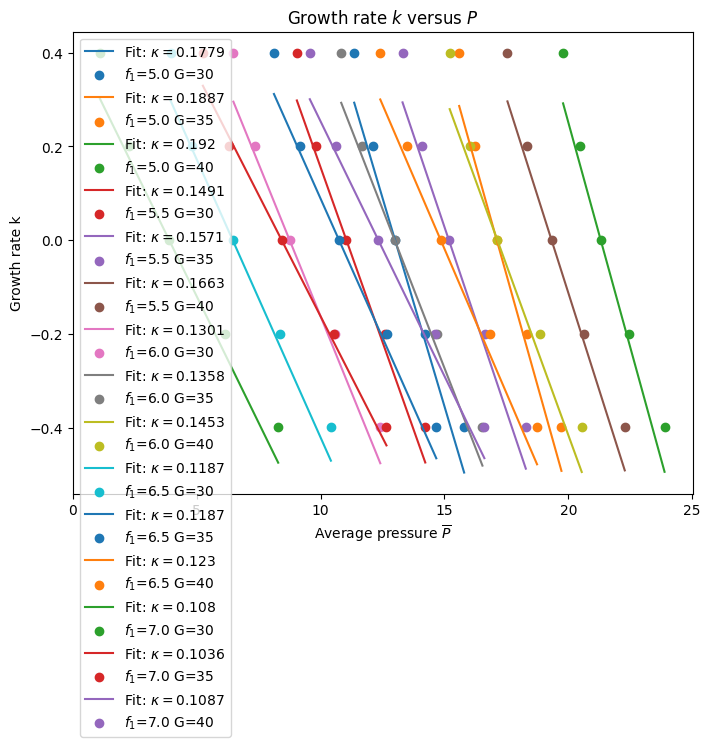

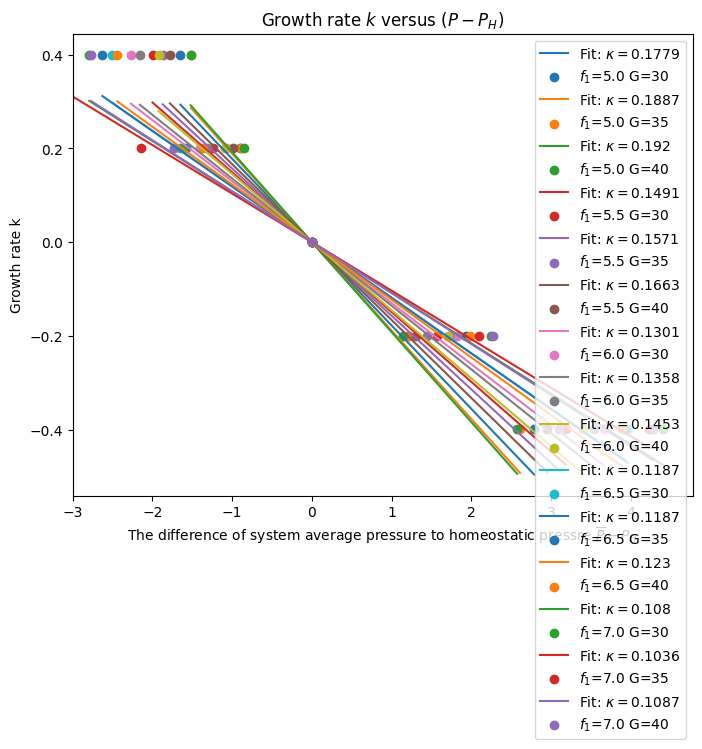

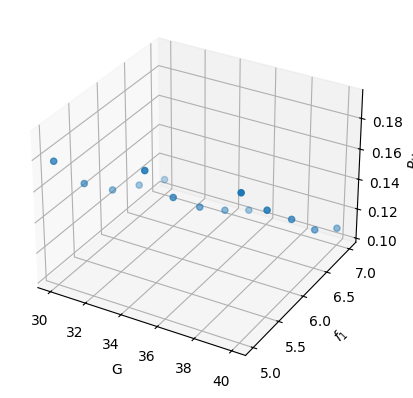

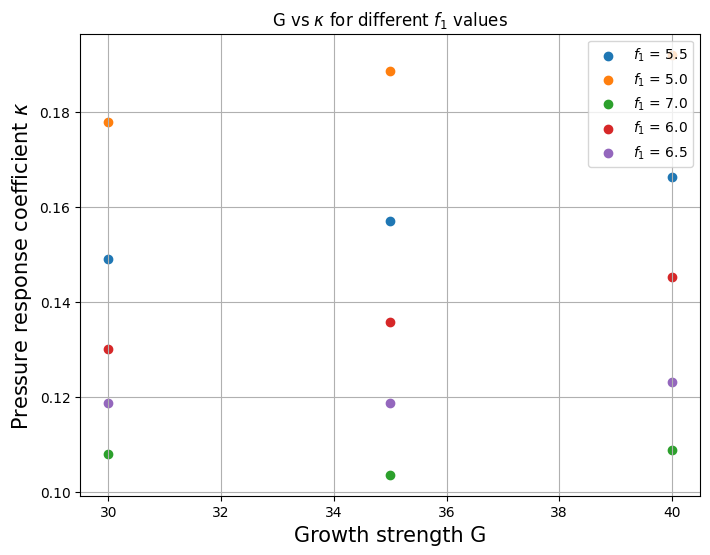

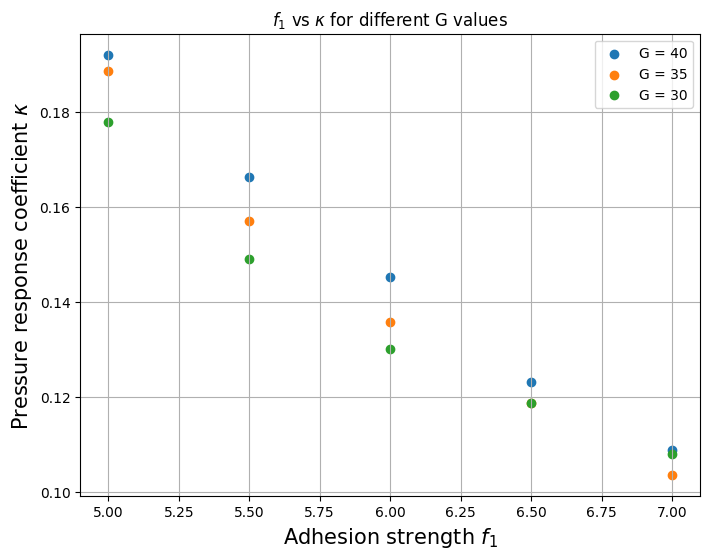

In [6]:
def kappa_func(dP,kappa):
    return kappa*dP
# Step 1: Navigate through folders
main_dir = './kappa_const_growth_rate2'
f1_folders = [folder for folder in os.listdir(main_dir) if folder.startswith('f1_')]
ka=0.01# apoptosis rate
G_values = []
f1_values = []
kappa_values = []
fig1,ax1 = plt.subplots(figsize=(8, 6))
fig2,ax2 = plt.subplots(figsize=(8, 6))

for f1_folder in f1_folders:
    f1_value = float(f1_folder.split('_')[1])  # Extract f1 value from folder name
    f1_path = os.path.join(main_dir, f1_folder)
    G_folders = [folder for folder in os.listdir(f1_path) if folder.startswith('G_')]
    
    for G_folder in G_folders:
        G_value = int(G_folder.split('_')[1])  # Extract G value from folder name
        G_path = os.path.join(f1_path, G_folder)
        subsubfolders = [folder for folder in os.listdir(G_path) if folder.startswith('scale_')]
        
        k_values = []
        delta_P_values = []
        P_values = []
        for subsubfolder in subsubfolders:
            scale_path = os.path.join(G_path, subsubfolder)
            
            # Step 2: Calculate homeostatic pressure
            if subsubfolder == 'scale_0':
                data = np.loadtxt(os.path.join(scale_path, '__curp.dat'))
                pressure = np.mean(data[50:, 1])  # Average pressure from time 50 to 400
                
        for subsubfolder in subsubfolders:
            scale_path = os.path.join(G_path, subsubfolder)            
            # Step 3: Calculate growth rate
            scale = int(subsubfolder.split('_')[-1])
            k = ((1 + 0.001 * scale)**2 - 1)/ka
            k_values.append(k)
            
            # Step 4: Calculate average pressure
            data = np.loadtxt(os.path.join(scale_path, '__curp.dat'))
            avg_pressure = np.mean(data[50:, 1])  # Average pressure from time 50 to 400
            
            delta_P = avg_pressure - pressure
            delta_P_values.append(delta_P)
            P_values.append(avg_pressure)
        
        # Step 5: Linear fitting for kappa
        slope, intercept, r_value, p_value, std_err = linregress(delta_P_values, k_values)
        kappa = -slope
        delta_P_space = np.linspace(delta_P_values[0],delta_P_values[-1],10)
        ax1.plot(delta_P_space+pressure,kappa_func(delta_P_space,slope),label=f'Fit: $\kappa=${np.round(kappa,4)}')
        ax1.scatter(delta_P_values+pressure,k_values,label=f'$f_1$={f1_value} G={G_value}')     
        ax1.set_title(r'Growth rate $k$ versus $P$')
        
        ax2.plot(delta_P_space,kappa_func(delta_P_space,slope),label=f'Fit: $\kappa=${np.round(kappa,4)}')
        ax2.scatter(delta_P_values,k_values,label=f'$f_1$={f1_value} G={G_value}')     
        ax2.set_title(r'Growth rate $k$ versus $(P - P_H)$')
        G_values.append(G_value)
        f1_values.append(f1_value)
        kappa_values.append(kappa)
ax1.set_xlabel(r'Average pressure $\overline{P}$')
ax1.set_ylabel(r'Growth rate k')
ax1.set_xlim(0)

ax2.set_xlabel(r'The difference of system average pressure to homeostatic pressre $\overline{P} - P_H$')
ax2.set_ylabel(r'Growth rate k')
ax2.set_xlim(-3)
ax1.legend()
ax2.legend()

G_values = np.array(G_values)
f1_values = np.array(f1_values)
kappa_values = np.array(kappa_values)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(G_values, f1_values, kappa_values, label='Data')
ax.set_xlabel('G')
ax.set_ylabel('$f_1$')
ax.set_zlabel('$P_H$')

unique_f1_values = set(f1_values)
plt.figure(figsize=(8, 6)) 

for f1 in unique_f1_values:
    indices = [i for i, value in enumerate(f1_values) if value == f1]
    G_subset = [G_values[i] for i in indices]
    kappa_subset = [kappa_values[i] for i in indices]
    plt.scatter(G_subset, kappa_subset, label=f'$f_1$ = {f1}')

plt.xlabel('Growth strength G',fontsize=15)
plt.ylabel(r'Pressure response coefficient $\kappa$',fontsize=15)
plt.legend()
plt.title(r'G vs $\kappa$ for different $f_1$ values')
plt.grid(True)
plt.show()

unique_G_values = set(G_values)

plt.figure(figsize=(8, 6))  

for g in unique_G_values:
    indices = [i for i, value in enumerate(G_values) if value == g]
    f1_subset = [f1_values[i] for i in indices]
    kappa_subset = [kappa_values[i] for i in indices]
    plt.scatter(f1_subset, kappa_subset, label=f'G = {g}')

indices = [i for i, value in enumerate(G_values) if value == g]
f1_subset_const_growth = [f1_values[i] for i in indices]
kappa_list_const_growth = [kappa_values[i] for i in indices]


plt.xlabel('Adhesion strength $f_1$',fontsize=15)
plt.ylabel(r'Pressure response coefficient $\kappa$',fontsize=15)
plt.legend()
plt.title('$f_1$ vs $\kappa$ for different G values')
plt.grid(True)

After investigating the effects of G and $f_1$ on $\kappa$, we observed that the value of $\kappa$ exhibits a first-order linear approximation with respect to G and $f_1$. This relationship can be expressed by the formula $\kappa \approx a_{\kappa} G + b_{\kappa} f_1 + c_{\kappa}$, where $a_{\kappa}$, $b_{\kappa}$, and $c_{\kappa}$ are constants.

__III.Tissue competition solely depdent on homeostatic pressure__

In last two section, we performed the simulation to measure the pressure-response coefficient $\kappa$.
In this section, we will examine if the $\kappa$ measured in last section is compatible with tissue competition. 

In tissue competition solely depdent on homeostatic pressure, the concept of homeostatic pressure is originally used to explain the competition of two species.The fraction of the species with higher homeostatic pressure will follows the logistic manner and wins the competition. The simulation of competition between two species with different homeostatic pressure will be conducted to examine the thoery.

__III.1 Theory__

With the assumption of incompressibility of tissue and identical pressure response $\kappa$ of both tissues, the total cell number $N_{tot} = N_A +N_B$ is conserved and $\kappa_A = \kappa_B = \kappa$. The dynamical system is:
\begin{equation}
\partial_t N_A = \kappa(P_H^A-P)N_A
\end{equation}

\begin{equation}
\partial_t N_B = \kappa(P_H^B-P)N_B
\end{equation}

Divide the two sides of both equations by $N_{tot}$

\begin{equation}
\partial_t \phi = \kappa(P_H^A-P)\phi
\end{equation}

\begin{equation}
\partial_t (1-\phi) = \kappa(P_H^B-P)(1-\phi)
\end{equation}

Sum up the above two equations, we can get the relation between P and $\phi$:
\begin{equation}
P = P_H^A \phi + P_H^B (1-\phi)
\end{equation}

Plug the formula of P into one of dynamical system equation, we get:
\begin{equation}
\partial_t \phi = \kappa (P_H^A- P_H^B)\phi(1-\phi) = \kappa \Delta P_H \phi(1-\phi)
\end{equation} 

The general solution of the above differential equation is:
\begin{equation}
\phi = \frac{1}{1+e^{-\kappa \Delta P_H (t-t_0)}}
\end{equation}
__III.2 Simulation__

To research on the simple tissue competition case, the simulation set up are following:
Keep the $f_1=f_1^A=f_1^B$ but change $f_1$ in the range of 5 to 6 with the interval of 1.
In each adhesion strength $f_1$, I fix the $G_B=35$ and change $G_A$ in the range of 35.5 to 37.5 with the interval of 0.5(small deviation around reference value). 

In the simulation, the initial fraction of specie A $\phi$ is always 0.05. 
Our goal is to curvefit the $\phi$ as a function of time, therefore $\kappa \Delta P_H$ can be acquired from the dynamics. $\Delta P_H$ can be directly calculated by the formula of $P_H$ linear approximation. Thus we can plot a picture of $\kappa \Delta P_H$ as a function of $\Delta P_H$, and the slope of the data is expected as around $\kappa$ by this theory.  



Text(0, 0.5, '$\\kappa$')

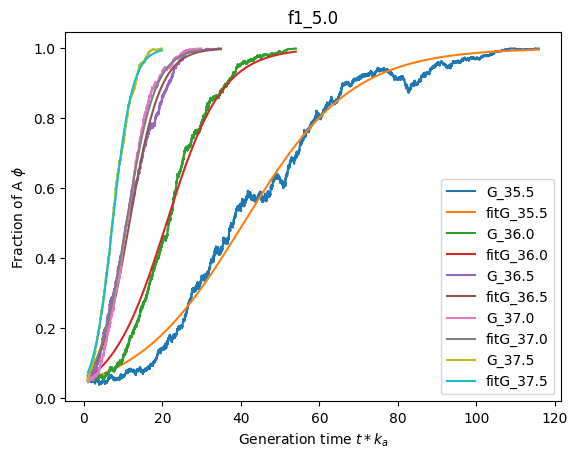

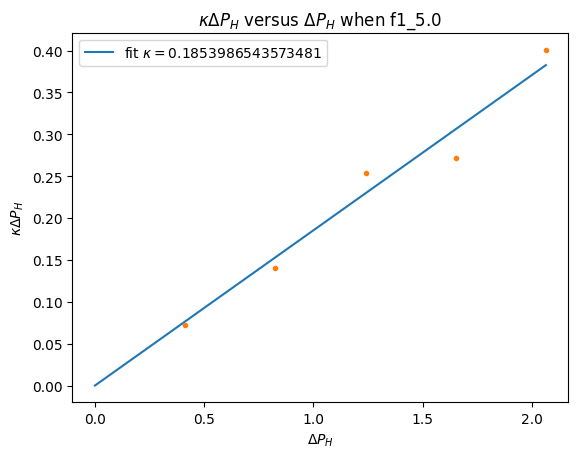

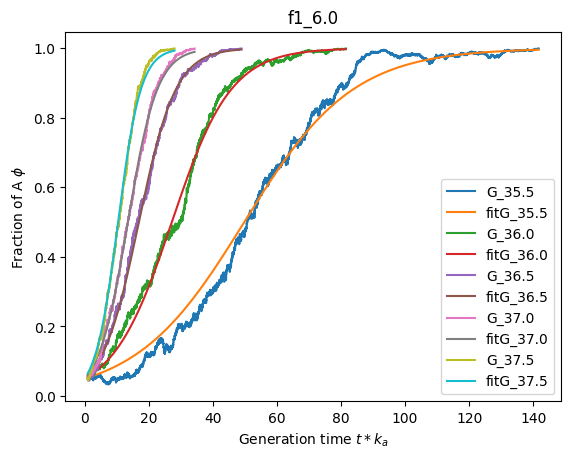

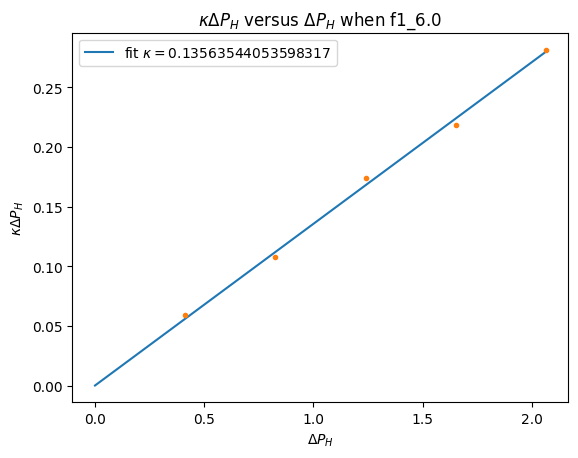

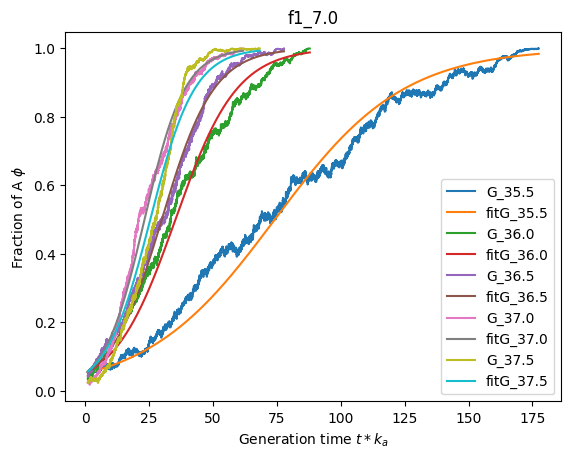

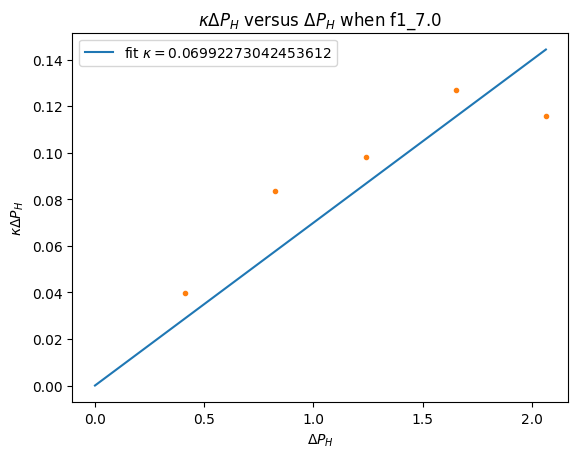

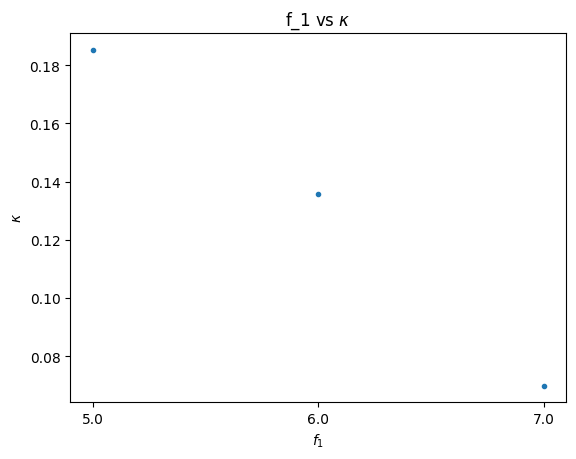

In [7]:
#one exmaple
# Constants
a_fit = 0.8255197434137439
b_fit = -4.433211634010404
c_fit = 10.164378211438262
a = a_fit
b = -b_fit

def fit_func(t,kph):
    phi = 1/(1+np.exp(-kph*t)*19)
    return phi

def fit_kappa(ph,kappa):
    kph = kappa*ph
    return kph
folder_path = r'./2023-11-simple-competition'
folders = sorted([f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f)) and f.startswith('f1')])
kappa_list_flat = []
f1_list = []
for folder in folders:
    f1_list.append(folder.split('_')[-1])
    sub_folders = sorted([f for f in os.listdir(os.path.join(folder_path, folder)) if os.path.isdir(os.path.join(folder_path, folder, f)) and f.startswith('G')])
    sub_folders.sort(key=lambda x: float(x.split("_")[1]))
    plt.figure()
    kph_list = []
    deltaph_list = []
    for sub_folder in sub_folders:
        numcells_path = os.path.join(folder_path,folder,sub_folder,'numcells.dat')
        try:
            numcells_data = pd.read_csv(numcells_path,sep='\t')
            numcells_data['fraction'] = numcells_data.iloc[:,2]/(numcells_data.iloc[:,2]+numcells_data.iloc[:,1])
            numcells_data['time'] = numcells_data.iloc[:,0]/100
            time_data = numcells_data['time'][100:]
            fraction_data = numcells_data['fraction'][100:]
            plt.plot(time_data,fraction_data,label=str(sub_folder))
            plt.title(str(folder))
            plt.xlabel(r'Generation time $t*k_a$')
            plt.ylabel(r'Fraction of A $\phi$')
            popt,pcov = curve_fit(fit_func,time_data,fraction_data)
            fit_fraction_data = fit_func(time_data,*popt)
            plt.plot(time_data,fit_fraction_data,label='fit'+str(sub_folder))
            kph,deltaph = popt[0],(float(sub_folder.split('_')[1])-35)*a
            kph_list.append(kph)
            deltaph_list.append(deltaph)
        except:
            continue
    plt.legend()
    plt.figure()
    popt,_ = curve_fit(fit_kappa,deltaph_list,kph_list)
    kappa_list_flat.append(popt[0])
    deltaph_fit = np.linspace(0,np.max(deltaph_list),100)
    kph_fit = fit_kappa(deltaph_fit,*popt)
    plt.plot(deltaph_fit,kph_fit,label = r"fit $\kappa=$"+str(popt[0]))
    plt.plot(deltaph_list,kph_list,'.')
    plt.title(r'$\kappa \Delta P_H$ versus $\Delta P_H$ when '+str(folder))
    plt.xlabel(r'$\Delta P_H$')
    plt.ylabel(r'$\kappa \Delta P_H$')
    plt.legend()
plt.figure()
plt.plot(f1_list,kappa_list_flat,'.')
plt.title(r'f_1 vs $\kappa$')
plt.xlabel(r'$f_1$')
plt.ylabel(r'$\kappa$')

__III.3 Preliminary Result__

As what the theory expected, $\kappa \Delta P_H$ has a linear relation with $\Delta P_H$, but the slope in different $f_1$ is not the same. Does it mean they have different pressure response coefficient $\kappa$ in different $f_1$?  



III. (Flat initial setup): tissue competition solely dependent on homeostatic pressure 

set up: same as above and the same competition set up has been repeated for 10 times.

Analysis steps:
1. loop the 'f1_*'folder in the relative path './2024-3-tissue-competition',here 'f1' means adhesion strength.
2. loop the 'G_*' subfolder in each 'f1_' folder, here 'G' means growth strength.
3. loop the 'rep_*' subsubfolder in each 'G_' folder, here 'rep' means repetition times.The same competition set up has been repeated for 10 times.
4. read_csv the file 'numcells.dat' and '__curp.dat' in each subsubfolder 'rep_*'. The first column of 'numcells.dat' contains the information of time, which start from 1 and increase with the interval 1, and the time in each row is different, the second column of 'numcells.dat' contains the information of cell number of A at the time, and third contains cell number of B at the time, the rest columns are not important. For file '__cupr.dat', the first column contains time, which start from 10 and increase with interval 10, and the time in each row is different, the second column contains the pressure at the time. Different files have different rows number. 
5. create two new dataframes which storage the average of cell fraction A at time, and average pressure at time in each 'f1' and 'G'. 
6. plot the figures of evolution of average of cell fraction A and evolution of average pressure in each 'f1' and 'G'
7. Use the fitting function to fit the the evolution of average of cell fraction A, and obtain the $\kappa \Delta P_H$ by fitting.  

[np.float64(0.19088361202051787), np.float64(0.16448717317709508), np.float64(0.13704580374648456), np.float64(0.11403840793658493), np.float64(0.08927989498903831)]


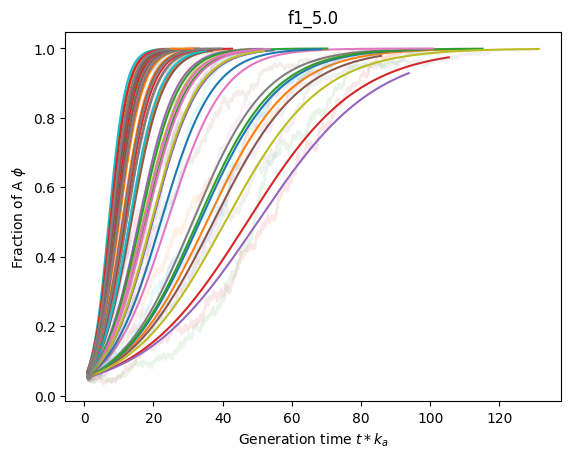

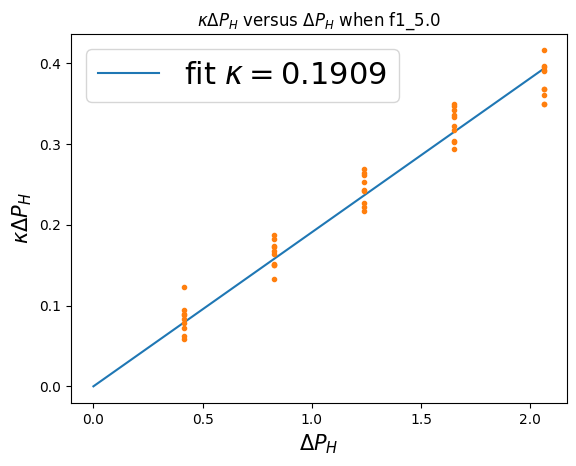

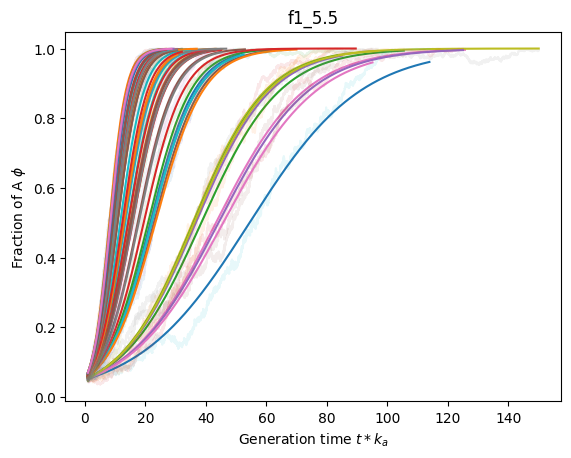

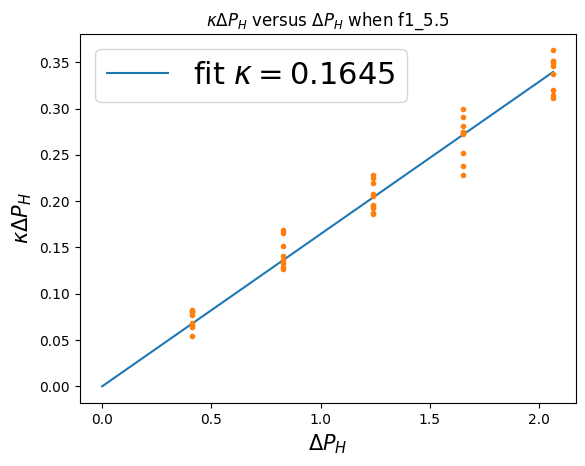

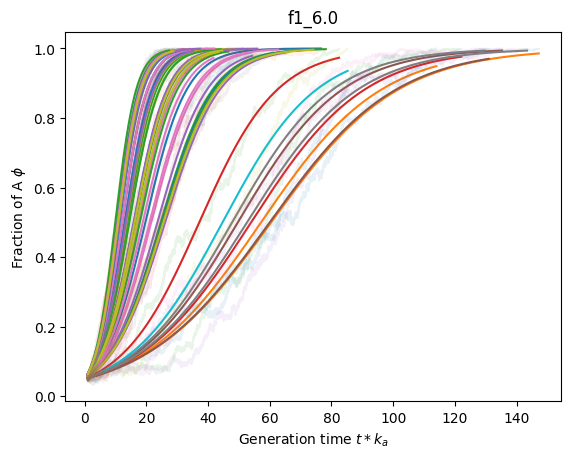

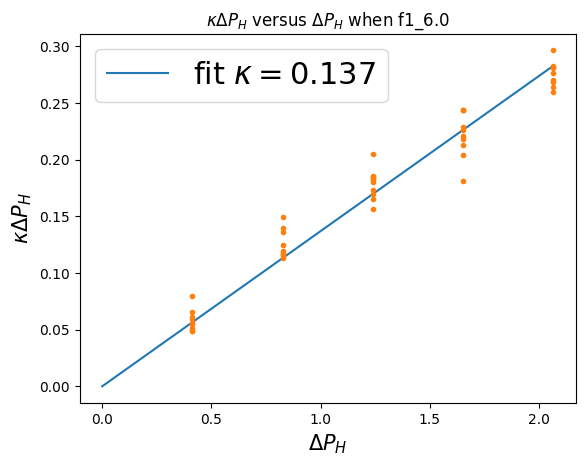

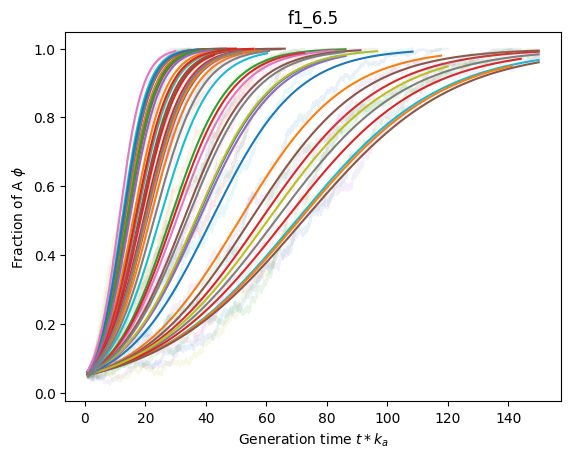

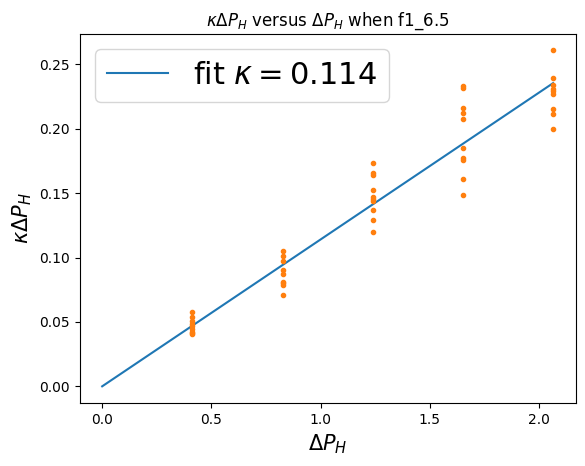

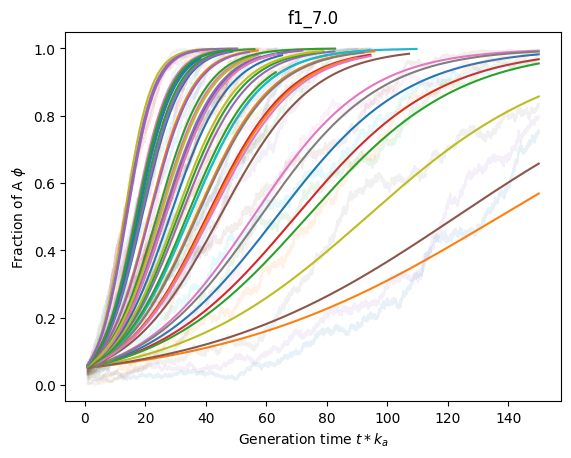

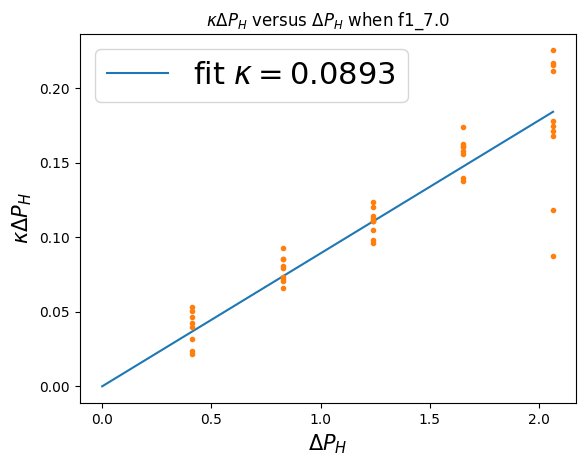

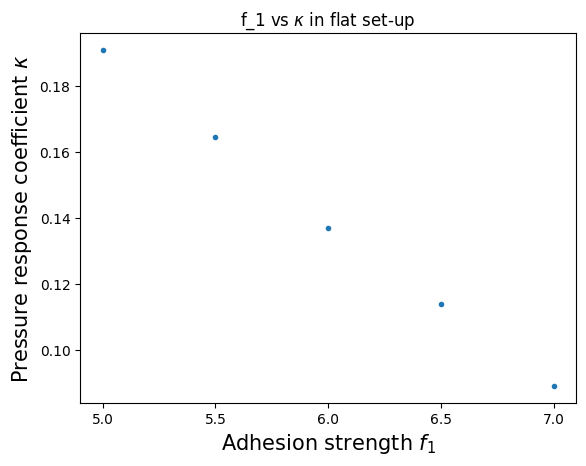

In [8]:
#one exmaple
# Constants
a_fit = 0.8255197434137439
b_fit = -4.433211634010404
c_fit = 10.164378211438262
a = a_fit
b = -b_fit

def fit_func(t,kph):
    phi = 1/(1+np.exp(-kph*t)*19)
    return phi

def fit_kappa(ph,kappa):
    kph = kappa*ph
    return kph
folder_path = r'./2024-3-tissue-competition-flat'
folders = sorted([f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f)) and f.startswith('f1')])
kappa_list_flat = []
f1_list = []
for folder in folders:
    f1_list.append(folder.split('_')[-1])
    sub_folders = sorted([f for f in os.listdir(os.path.join(folder_path, folder)) if os.path.isdir(os.path.join(folder_path, folder, f)) and f.startswith('G')])
    sub_folders.sort(key=lambda x: float(x.split("_")[1]))
    plt.figure()
    kph_list = []
    deltaph_list = []
    for sub_folder in sub_folders:
        subsub_folders = sorted([f for f in os.listdir(os.path.join(folder_path,folder,sub_folder)) if os.path.isdir(os.path.join(folder_path, folder,sub_folder, f)) and f.startswith('rep')])
        subsub_folders.sort(key=lambda x: float(x.split("_")[1]))
        for subsub_folder in subsub_folders:
            numcells_path = os.path.join(folder_path,folder,sub_folder,subsub_folder, 'numcells.dat')
            try:
                numcells_data = pd.read_csv(numcells_path,sep='\t')
                numcells_data['fraction'] = numcells_data.iloc[:,2]/(numcells_data.iloc[:,2]+numcells_data.iloc[:,1])
                numcells_data['time'] = numcells_data.iloc[:,0]/100
                time_data = numcells_data['time'][100:]
                fraction_data = numcells_data['fraction'][100:]
                plt.plot(time_data,fraction_data,alpha=0.1)
                plt.title(str(folder))
                plt.xlabel(r'Generation time $t*k_a$')
                plt.ylabel(r'Fraction of A $\phi$')
                popt,pcov = curve_fit(fit_func,time_data,fraction_data)
                fit_fraction_data = fit_func(time_data,*popt)
                plt.plot(time_data,fit_fraction_data)
                kph,deltaph = popt[0],(float(sub_folder.split('_')[1])-35)*a
                kph_list.append(kph)
                deltaph_list.append(deltaph)
            except:
                continue
    plt.figure()
    popt,_ = curve_fit(fit_kappa,deltaph_list,kph_list)
    kappa_list_flat.append(popt[0])
    deltaph_fit = np.linspace(0,np.max(deltaph_list),100)
    kph_fit = fit_kappa(deltaph_fit,*popt)
    plt.plot(deltaph_fit,kph_fit,label = r"fit $\kappa=$"+str(np.round(popt[0],4)))
    plt.plot(deltaph_list,kph_list,'.')
    plt.title(r'$\kappa \Delta P_H$ versus $\Delta P_H$ when '+str(folder))
    plt.xlabel(r'$\Delta P_H$',fontsize=15)
    plt.ylabel(r'$\kappa \Delta P_H$',fontsize=15)
    plt.legend(fontsize=22)
plt.figure()
plt.plot(f1_list,kappa_list_flat,'.')
plt.title(r'f_1 vs $\kappa$ in flat set-up')
plt.xlabel(r'Adhesion strength $f_1$',fontsize=15)
plt.ylabel(r'Pressure response coefficient $\kappa$',fontsize=15)
print(kappa_list_flat)

III. (Mixed initial setup): tissue competition solely dependent on homeostatic pressure

set up: same as above, the only difference is that in the starting point of the competition, the winning competitors are random mixed in the host tissue. And the same competition set up has been repeated for 10 times.

/tmp/ipykernel_1381/2304158159.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_1381/2304158159.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_1381/2304158159.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_1381/2304158159.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_1381/2304158159.py:50: UserWarning: No artists with labels found to put in legend.  Note that

Text(0, 0.5, 'Pressure response coefficient $\\kappa$')

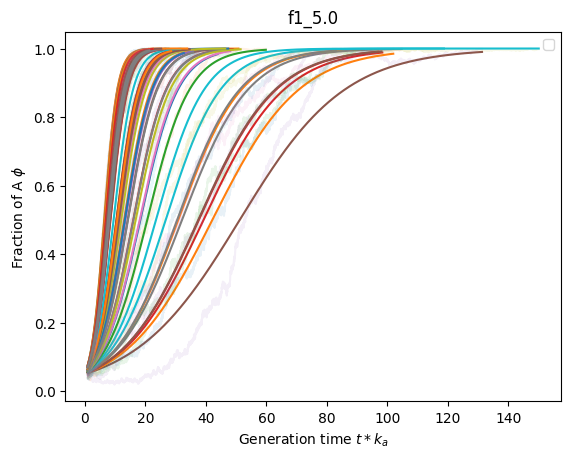

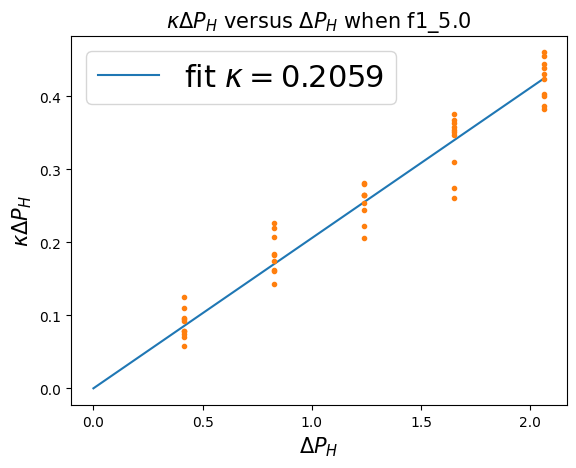

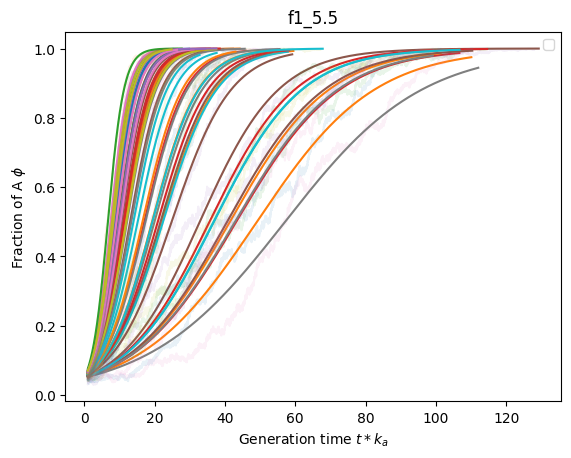

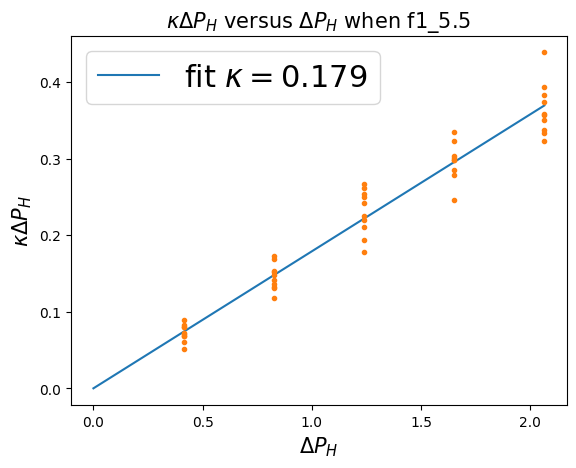

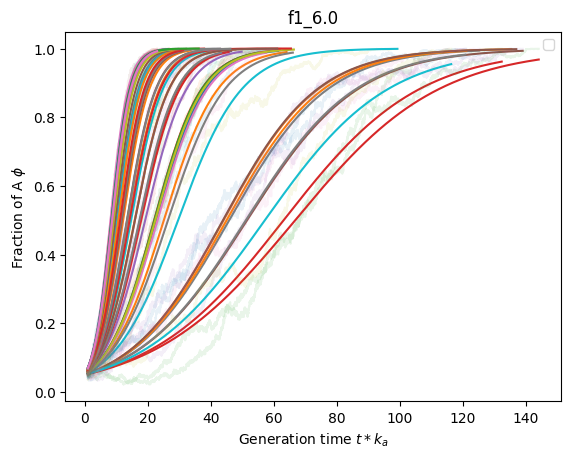

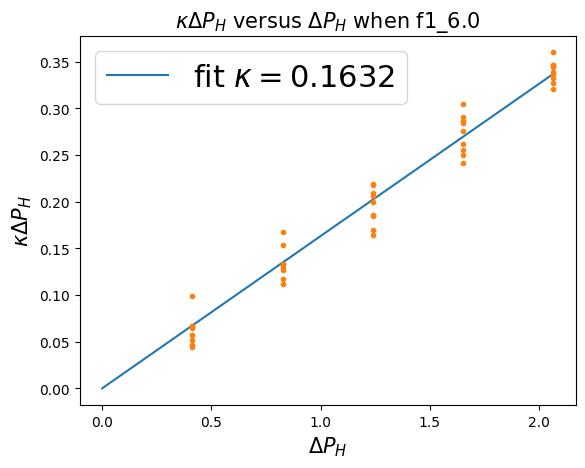

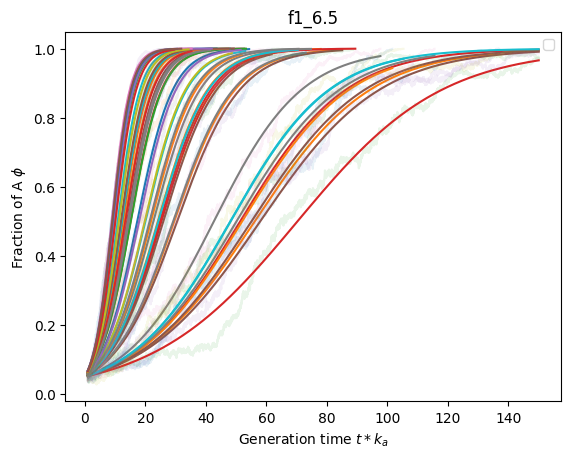

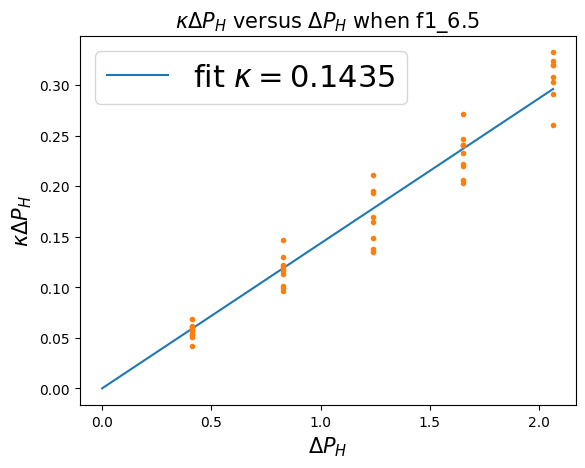

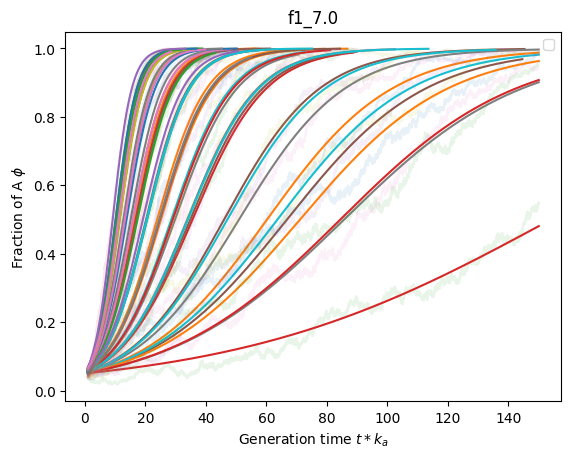

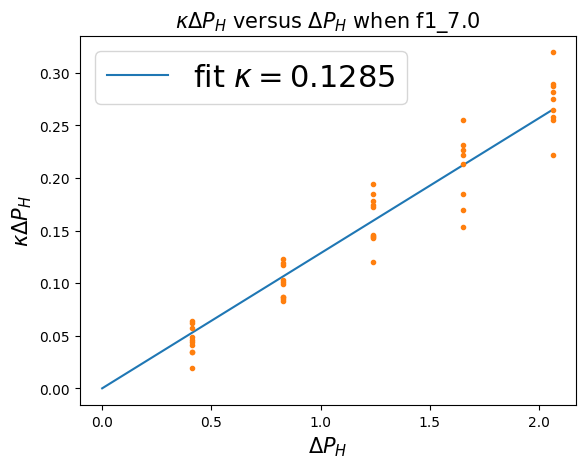

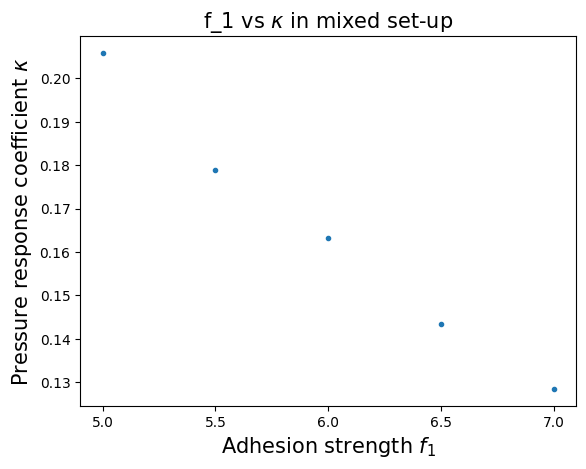

In [9]:
#one exmaple
# Constants
a_fit = 0.8255197434137439
b_fit = -4.433211634010404
c_fit = 10.164378211438262
a = a_fit
b = -b_fit

def fit_func(t,kph):
    phi = 1/(1+np.exp(-kph*t)*19)
    return phi

def fit_kappa(ph,kappa):
    kph = kappa*ph
    return kph
folder_path = r'./2024-3-tissue-competition'
folders = sorted([f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f)) and f.startswith('f1')])
kappa_list_mix = []
f1_list = []
for folder in folders:
    f1_list.append(folder.split('_')[-1])
    sub_folders = sorted([f for f in os.listdir(os.path.join(folder_path, folder)) if os.path.isdir(os.path.join(folder_path, folder, f)) and f.startswith('G')])
    sub_folders.sort(key=lambda x: float(x.split("_")[1]))
    plt.figure()
    kph_list = []
    deltaph_list = []
    for sub_folder in sub_folders:
        subsub_folders = sorted([f for f in os.listdir(os.path.join(folder_path,folder,sub_folder)) if os.path.isdir(os.path.join(folder_path, folder,sub_folder, f)) and f.startswith('rep')])
        subsub_folders.sort(key=lambda x: float(x.split("_")[1]))
        for subsub_folder in subsub_folders:
            numcells_path = os.path.join(folder_path,folder,sub_folder,subsub_folder, 'numcells.dat')
            try:
                numcells_data = pd.read_csv(numcells_path,sep='\t')
                numcells_data['fraction'] = numcells_data.iloc[:,1]/(numcells_data.iloc[:,2]+numcells_data.iloc[:,1])
                numcells_data['time'] = numcells_data.iloc[:,0]/100
                time_data = numcells_data['time'][100:]
                fraction_data = numcells_data['fraction'][100:]
                plt.plot(time_data,fraction_data,alpha=0.1)
                plt.title(str(folder))
                plt.xlabel(r'Generation time $t*k_a$')
                plt.ylabel(r'Fraction of A $\phi$')
                popt,pcov = curve_fit(fit_func,time_data,fraction_data)
                fit_fraction_data = fit_func(time_data,*popt)
                plt.plot(time_data,fit_fraction_data)
                kph,deltaph = popt[0],(float(sub_folder.split('_')[1])-35)*a
                kph_list.append(kph)
                deltaph_list.append(deltaph)
            except:
                continue
    plt.legend()
    plt.figure()
    popt,_ = curve_fit(fit_kappa,deltaph_list,kph_list)
    kappa_list_mix.append(popt[0])
    deltaph_fit = np.linspace(0,np.max(deltaph_list),100)
    kph_fit = fit_kappa(deltaph_fit,*popt)
    plt.plot(deltaph_fit,kph_fit,label = r"fit $\kappa=$"+str(np.round(popt[0],4)))
    plt.plot(deltaph_list,kph_list,'.')
    plt.title(r'$\kappa \Delta P_H$ versus $\Delta P_H$ when '+str(folder),fontsize=15)
    plt.xlabel(r'$\Delta P_H$',fontsize=15)
    plt.ylabel(r'$\kappa \Delta P_H$',fontsize=15)
    plt.legend(fontsize=22)
plt.figure()
plt.plot(f1_list,kappa_list_mix,'.')
plt.title(r'f_1 vs $\kappa$ in mixed set-up',fontsize=15)
plt.xlabel(r'Adhesion strength $f_1$',fontsize=15)
plt.ylabel(r'Pressure response coefficient $\kappa$',fontsize=15)

III.Results
For both initial geometry setups (flat and mixed), the value of $\kappa$ decreases as $f_1$ increases, exhibiting a linear trend. However, within the range of $f_1$ values from 5 to 7, the range of $\kappa$ differs slightly between the two cases. In the flat case, $\kappa$ ranges from 0.18 to 0.08, while in the mixed case, it ranges from 0.20 to 0.13. This indicates that there is a subtle statistical difference in $\kappa$ between the two cases.

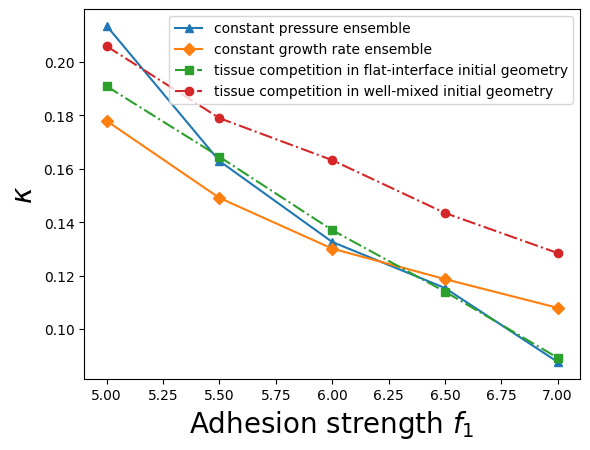

In [10]:
f1_list =[5+i*0.5 for i in range(5)]
plt.plot(f1_subset_const_pressure,kappa_list_const_pressure,marker='^',label='constant pressure ensemble')
plt.plot(f1_subset_const_growth,kappa_list_const_growth,marker='D',label='constant growth rate ensemble')
plt.plot(f1_list,kappa_list_flat,'-.',marker='s',label='tissue competition in flat-interface initial geometry')
plt.plot(f1_list,kappa_list_mix,'-.',marker='o', label='tissue competition in well-mixed initial geometry')
plt.xlabel(r'Adhesion strength $f_1$',fontsize='20')
plt.ylabel(r'$\kappa$',fontsize='20')
plt.legend()

__Appendix__

In this part, we perform simulations to investigate the effect of system size on competition with flat initial set-up. 

/tmp/ipykernel_1381/837250444.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_1381/837250444.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_1381/837250444.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Text(0, 0.5, '$\\kappa$')

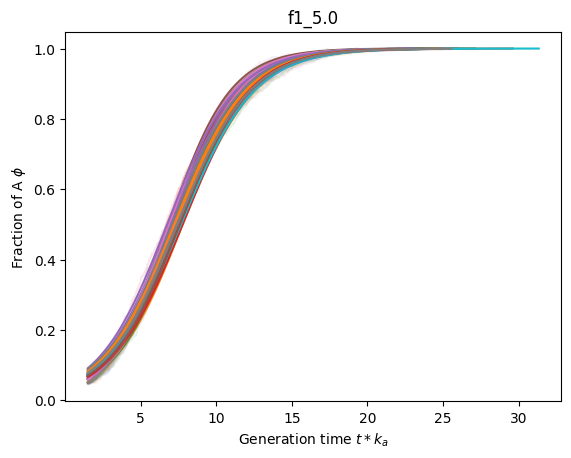

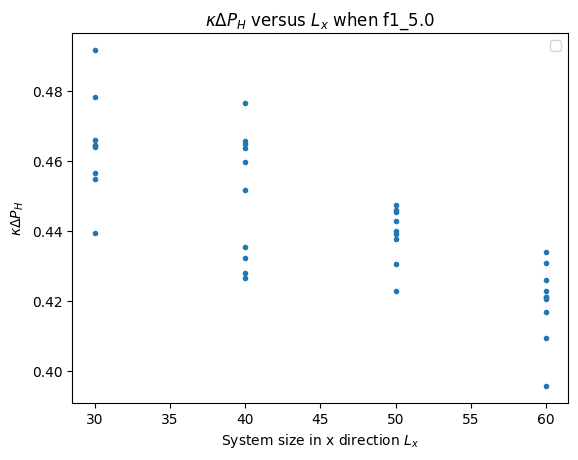

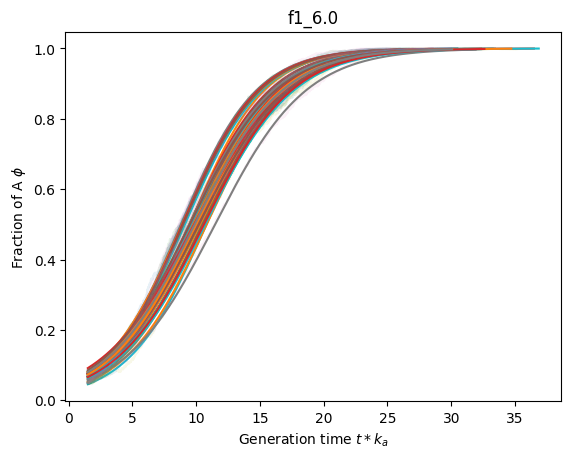

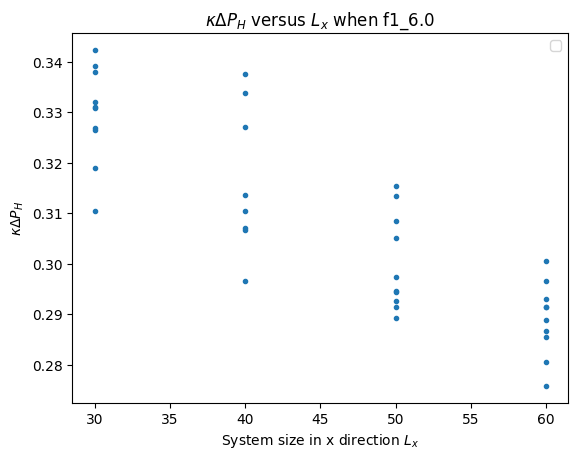

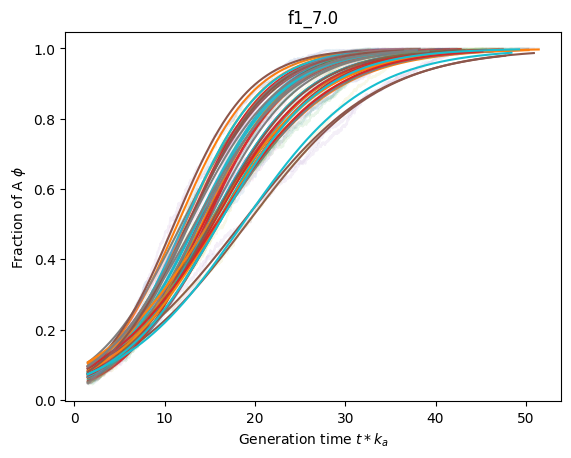

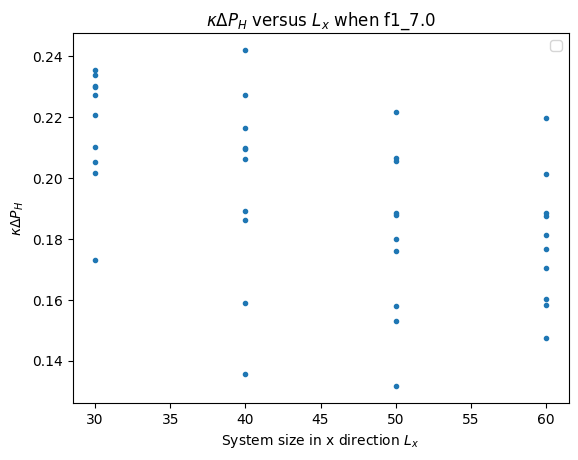

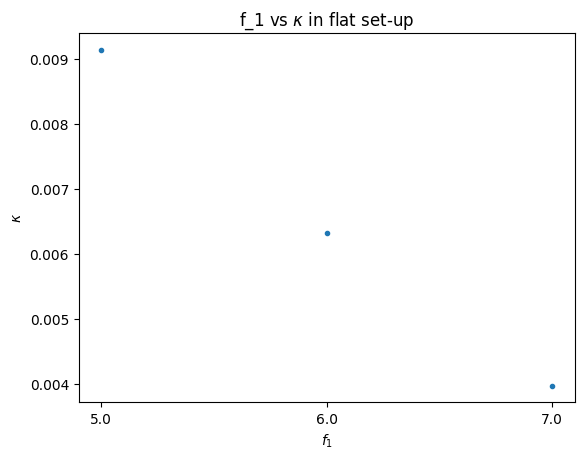

In [11]:
def fit_func(t,kph,t0):
    phi = 1/(1+np.exp(-kph*(t-t0)))
    return phi

folder_path = r'./2024-3-competition-size'
folders = sorted([f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f)) and f.startswith('f1')])
kappa_list = []
f1_list = []
starttime_competition=150
for folder in folders:
    f1_list.append(folder.split('_')[-1])
    sub_folders = sorted([f for f in os.listdir(os.path.join(folder_path, folder)) if os.path.isdir(os.path.join(folder_path, folder, f)) and f.startswith('x')])
    sub_folders.sort(key=lambda x: float(x.split("_")[1]))
    plt.figure()
    kph_list = []
    deltaph_list = []
    for sub_folder in sub_folders:
        subsub_folders = sorted([f for f in os.listdir(os.path.join(folder_path,folder,sub_folder)) if os.path.isdir(os.path.join(folder_path, folder,sub_folder, f)) and f.startswith('rep')])
        subsub_folders.sort(key=lambda x: float(x.split("_")[1]))
        for subsub_folder in subsub_folders:
            numcells_path = os.path.join(folder_path,folder,sub_folder,subsub_folder, 'numcells.dat')
            try:
                numcells_data = pd.read_csv(numcells_path,sep='\t')
                numcells_data['fraction'] = numcells_data.iloc[:,2]/(numcells_data.iloc[:,2]+numcells_data.iloc[:,1])
                numcells_data['time'] = numcells_data.iloc[:,0]/100
                time_data = numcells_data['time'][starttime_competition:]
                fraction_data = numcells_data['fraction'][starttime_competition:]
                plt.plot(time_data,fraction_data,alpha=0.1)
                plt.title(str(folder))
                plt.xlabel(r'Generation time $t*k_a$')
                plt.ylabel(r'Fraction of A $\phi$')
                popt,pcov = curve_fit(fit_func,time_data,fraction_data)
                fit_fraction_data = fit_func(time_data,*popt)
                plt.plot(time_data,fit_fraction_data)
                kph,deltaph = popt[0],float(sub_folder.split('_')[1])
                kph_list.append(kph)
                deltaph_list.append(deltaph)
            except:
                continue
    plt.figure()
    popt,_ = curve_fit(fit_kappa,deltaph_list,kph_list)
    kappa_list.append(popt[0])
    deltaph_fit = np.linspace(0,np.max(deltaph_list),100)
    kph_fit = fit_kappa(deltaph_fit,*popt)
    #plt.plot(deltaph_fit,kph_fit,label = r"fit $\kappa=$"+str(popt[0]))
    plt.plot(deltaph_list,kph_list,'.')
    plt.title(r'$\kappa \Delta P_H$ versus $L_x$ when '+str(folder))
    plt.xlabel(r'System size in x direction $L_x$')
    plt.ylabel(r'$\kappa \Delta P_H$')
    plt.legend()
plt.figure()
plt.plot(f1_list,kappa_list,'.')
plt.title(r'f_1 vs $\kappa$ in flat set-up')
plt.xlabel(r'$f_1$')
plt.ylabel(r'$\kappa$')